In [1]:
!nvidia-smi

Thu Jun  2 16:10:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 N/A |                  N/A |
| N/A   47C    P0    N/A /  N/A |      0MiB /  2004MiB |     N/A      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Data Loading

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# DL-CI-build dataset (lstm)
columns = ['build_Failed', 'gh_is_pr', 'git_prev_commit_resolution_status',
    'gh_team_size', 'gh_num_commit_comments', 'git_diff_src_churn',
    'git_diff_test_churn', 'gh_diff_files_added', 'gh_diff_files_deleted',
    'gh_diff_files_modified', 'gh_diff_tests_added',
    'gh_diff_tests_deleted', 'gh_diff_src_files', 'gh_diff_doc_files',
    'gh_diff_other_files', 'gh_sloc', 'gh_test_lines_per_kloc',
    'gh_test_cases_per_kloc', 'gh_asserts_cases_per_kloc', 'tr_build_id',
    'gh_build_started_at']

path = '/mnt/d/PFE/Code/CI-Failing-Builds-Detection/dataset'
path = '/content/drive/MyDrive/CI/replicating-ets/DL-CIBuild/dataset'
valid_proj = 'ruby.csv'
cols_to_keep = 18

# skipCI dataset
columns = ['ci_skipped', 'ns', 'nd', 'nf', 'entropy', 'la', 'ld', 'lt', 'ndev',
       'age', 'nuc', 'exp', 'rexp', 'sexp', 'TFC', 'is_doc', 'is_build',
       'is_meta', 'is_media', 'is_src', 'is_merge', 'FRM', 'COM', 'CFT',
       'classif', 'prev_com_res', 'proj_recent_skip', 'comm_recent_skip',
       'same_committer', 'is_fix', 'day_week', 'CM', 'commit_hash']

path = '/content/drive/MyDrive/CI/SkipCI-dataset'
path = '/mnt/d/PFE/Papers Presentations/1SkipCI/SkipCI/dataset/'

# projects list: 
# candybar-library.csv  GI.csv               mtsar.csv     ransack.csv     SemanticMediaWiki.csv
# contextlogger.csv     grammarviz2_src.csv  parallec.csv  SAX.csv         solr-iso639-filter.csv
# future.csv            groupdate.csv        pghero.csv    searchkick.csv  steve.csv

valid_proj = 'candybar-library.csv'
cols_to_keep = 32


#### Validation on all data

In [2]:
df = pd.DataFrame(columns=columns, dtype='object')

for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename[-4:]==".csv":
            df = pd.concat([df, pd.read_csv(os.path.join(dirname, filename))])

X = df.iloc[:,1:cols_to_keep]
y = df.iloc[:,0].astype(int)

from sklearn.model_selection import train_test_split
X_train, X_val , y_train, y_val = train_test_split(np.array(X), np.array(y), test_size=0.2, shuffle=True, stratify=y, random_state=42) # keep ratio of classes in split

eval_meth = 'eval_on_all_data'

#### Within project validation

In [3]:
df = pd.read_csv(os.path.join(path, valid_proj))
X = df.iloc[:,1:cols_to_keep]
y = df.iloc[:,0].astype(int)

from sklearn.model_selection import train_test_split
X_train, X_val , y_train, y_val = train_test_split(np.array(X), np.array(y), test_size=0.2, shuffle=True, stratify=y, random_state=42) # keep ratio of classes in split

eval_meth = f'within_proj_{valid_proj}'[:-4]

#### Cross project validation

In [4]:
df_train = pd.DataFrame(columns=columns, dtype='object')
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename[-4:]==".csv" and filename!=valid_proj:
            df_train = pd.concat([df_train, pd.read_csv(os.path.join(dirname, filename))])

X_train = np.array(df_train.iloc[:,1:cols_to_keep])
y_train = np.array(df_train.iloc[:,0].astype(int))

df_val = pd.read_csv(os.path.join(path, valid_proj))
df = df_val 

X_val = np.array(df_val.iloc[:,1:cols_to_keep])
y_val = np.array(df_val.iloc[:,0].astype(int))

eval_meth = f'cross_proj_{valid_proj}'[:-4]

### Modifiable Decision Tree model 

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import f1_score 
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import confusion_matrix


class modDecisionTree:
    """
    Represents the classification model
    based on sklearn implementation with added methods for modifying single nodes
    nodes are indexed depth first
    """


    def __init__(self, max_depth=3, random_state=42):
        # need to add init of other hyper-param
        self.max_depth = max_depth
        self.model = DecisionTreeClassifier(max_depth=max_depth, splitter='random', random_state=random_state)
    

    def fit(self, X_train, y_train, columns_names):
        self.model.fit(X_train, y_train)
        self.tree = self.model.tree_
        self.n_nodes = self.tree.node_count       # nbr of nodes
        self.features = self.tree.feature         # list of each node's feature
        self.thresholds = self.tree.threshold     # list of each node's threshold
        self.columns_names = columns_names
        self.features_names = [list(self.columns_names)[i] for i in self.features]
        self.nodes_type = self.get_nodes_type()  # a node is either a split node or a terminal node/leaf


    def evaluate(self, X_val, y_val, reward_only=True, print_confusion=False):
        y_pred = self.model.predict(X_val)
        metrics = {}
        metrics['F1'] = f1_score(y_val, y_pred)
        if not reward_only:
            metrics['recall'] = recall_score(y_val, y_pred)
            metrics['precision'] = precision_score(y_val, y_pred)
            metrics['accuracy'] = accuracy_score(y_val, y_pred)
            metrics['AUC'] = roc_auc_score(y_val, y_pred)
        if print_confusion:
            print(confusion_matrix(y_val, y_pred))
        return metrics


    def feature_importance(self):
        feat_imp = []
        for name, importance in zip(self.features_names , self.model.feature_importances_):
            feat_imp.append((name, importance))
        feat_imp.sort(key=lambda t:t[1], reverse=True)
        return feat_imp


    def plot_tree(self):
        plt.figure(figsize=(15,10))  # set plot size (denoted in inches)
        tree.plot_tree(self.model, fontsize=10, class_names=['pass','fail'])
        plt.show()


    def get_nodes_type(self):
        children_left = self.tree.children_left
        children_right = self.tree.children_right
        node_depth = np.zeros(shape=self.n_nodes, dtype=np.int64)
        is_leaves = np.zeros(shape=self.n_nodes, dtype=bool)
        stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
        while len(stack) > 0:
            # 'pop' ensures each node is only visited once
            node_id, depth = stack.pop()
            node_depth[node_id] = depth
            # If the left and right child of a node is not the same we have a split node
            is_split_node = children_left[node_id] != children_right[node_id]
            # If a split node, append left and right children and depth to `stack`
            # so we can loop through them
            if is_split_node:
                stack.append((children_left[node_id], depth + 1))
                stack.append((children_right[node_id], depth + 1))
            else:
                is_leaves[node_id] = True
        return is_leaves


    def node_is_leaf(self, node):
        """Returns whether a node is a leaf (terminal node) or a split node"""
        return self.nodes_type[node]==1


    def set_node_threshold(self, node, value):
        if node>=self.tree.node_count:
            print("Error: selected node id is not in the tree.")
            return
        if self.node_is_leaf(node):
            print("Error: can't change a leaf node's threshold.")
            return
        self.thresholds[node] = value 


    def set_node_feature(self, node, feat_index=None, feat_name=None):
        if node>=self.tree.node_count:
            print("Error: selected node id is not in the tree.")
            return
        if self.node_is_leaf(node):
            print("Error: can't change a terminal node's feature.")
            return
        # convert feature name to index if supplied with name
        if feat_index==None:
            feat_index = self.features_names.index(feat_name)
        self.features[node] = feat_index

### State Generation

#### Meth1

In [6]:
def tree_convolution_1(model, features, thresholds, node=0):
    """
        convolution of each 3 nodes, with overlapping => child of 1 subtree is parent of the next
        => after each conv, slit nodes' featuress and thresholdss are updated and terminal nodes are removed
        returns new features,thresholds values as lists
    """
    visited = []
    queue = []
    visited.append(node)
    queue.append(node)
    new_features = features
    new_thresholds = thresholds

    # BFS traversal
    while queue:
        node = queue.pop(0) 
        left_node = model.tree.children_left[node]
        right_node = model.tree.children_right[node]
        #print (node, left_node, right_node, end = "\n")
        if left_node not in visited:
            visited.append(left_node)
            queue.append(left_node)
        if right_node not in visited:
            visited.append(right_node)
            queue.append(right_node)

        # define kernel here
        if features[left_node]==-2 and features[right_node]==-2: # both child nodes are leaves
            new_node_features = -2
            new_node_thresholds = 0
        elif features[left_node]==-2: # left node is leaf
            new_node_features = (features[node]+features[right_node])/2
            new_node_thresholds = (thresholds[node]+thresholds[right_node])/2
        elif features[right_node]==-2: # right node is leaf
            new_node_features = (features[node]+features[left_node])/2
            new_node_thresholds = (thresholds[node]+thresholds[left_node])/2
        else:
            new_node_features = (features[node]+features[left_node]+features[right_node])/3
            new_node_thresholds = (thresholds[node]+thresholds[left_node]+thresholds[right_node])/3
        # save new values
        new_features[node] = new_node_features # will auto convert to int 
        new_thresholds[node] = new_node_thresholds

    return new_features, new_thresholds


def flatten(features, thresholds):
    # removing null values
    clean_feat, clean_thres = [], []
    for i in range(len(features)):
        if features[i]!=-2:
            clean_feat.append(features[i])
            clean_thres.append(thresholds[i])
    return torch.cat((torch.FloatTensor(clean_feat), torch.FloatTensor(clean_thres))).to(device)


def generate_state_1(model, features, thresholds, nbr_of_conv):
    features, thresholds = features.copy(), thresholds.copy()
    for _ in range(nbr_of_conv):
        new_features, new_thresholds = tree_convolution_1(model, features, thresholds) # model must be fitted => add condition?
        features, thresholds = new_features, new_thresholds
    return flatten(features, thresholds)


#### Meth2: 1 hot enc

In [7]:
from sklearn.preprocessing import OneHotEncoder


def tree_convolution_2(model, encoded_nodes, node=0):
    """
        convolution of each 3 nodes, with overlapping => child of 1 subtree is parent of the next
        => after each conv, slit nodes' featuress and thresholdss are updated and terminal nodes are removed
        takes a 1 hot representation of a tree and returns it after one convolution (same shape)
    """
    new_encoded_nodes = encoded_nodes.copy()
    
    visited = []
    queue = []
    visited.append(node)
    queue.append(node)
    # BFS traversal
    while queue:
        node = queue.pop(0) 
        left_node = model.tree.children_left[node]
        right_node = model.tree.children_right[node]
        #print (node, left_node, right_node, end = "\n")
        if left_node not in visited:
            visited.append(left_node)
            queue.append(left_node)
        if right_node not in visited:
            visited.append(right_node)
            queue.append(right_node)

        # define kernel here
        if encoded_nodes[left_node] is None and encoded_nodes[right_node] is None: # both child nodes are leaves
            new_enc_node = None
        elif encoded_nodes[left_node] is None: # left node is leaf
            vect1 = encoded_nodes[node]
            vect2 = encoded_nodes[right_node]
            new_enc_node = node_aggregate(vect1, vect2)
        elif encoded_nodes[right_node] is None: # right node is leaf
            vect1 = encoded_nodes[node]
            vect2 = encoded_nodes[left_node]
            new_enc_node = node_aggregate(vect1, vect2)
        else:
            vect1 = encoded_nodes[node]
            vect2 = encoded_nodes[left_node]
            vect3 = encoded_nodes[right_node]
            new_enc_node = node_aggregate(vect1, vect2, vect3)
        # save new values
        new_encoded_nodes[node] = new_enc_node

    return new_encoded_nodes


def node_aggregate(vect1, vect2, vect3=None):
    """
        given 2 or 3 vectors,
        for all attributes
        if all vectors contain the same attribute, this will average them
        else it will keep the non null value
    """
    out = vect1
    if vect3 is None:
        for i in range(number_of_attributes):
            if vect1[i]!=0 and vect2[i]==0:
                out[i] = vect1[i]
            if vect1[i]!=0 and vect2[i]!=0:
                out[i] = (vect1[i]+vect2[i])/2
    else:
        for i in range(number_of_attributes):
            if vect1[i]==0:
                if vect2[i]!=0 and vect3[i]!=0:
                    out[i] = (vect2[i]+vect3[i])/2
                if vect2[i]==0 and vect3[i]!=0:
                    out[i] = vect3[i]
                if vect2[i]!=0 and vect3[i]==0:
                    out[i] = vect2[i]

            else:
            # if vect1[i]!=0:
                if vect2[i]!=0 and vect3[i]!=0:
                    out[i] = (vect1[i]+vect2[i]+vect3[i])/2
                if vect2[i]==0 and vect3[i]!=0:
                    out[i] = (vect1[i]+vect3[i])/2
                if vect2[i]!=0 and vect3[i]==0:
                    out[i] = (vect1[i]+vect2[i])/2
    return out


def encode_tree(model):
    """
        Creates a vector representation to a decision tree
        each node is represented by a 1 hot vector containing the threshold at the attribute's index
        output is 1D Tensor of node representations
    """
    # fit 1 hot encoder
    enc = OneHotEncoder()
    arr = np.array(range(number_of_attributes)).reshape(-1, 1)
    enc.fit(arr)

    # build init vect
    n = len(model.features)
    encoded_nodes = []
    for i in range(n):
        feat, thres = model.features[i], model.thresholds[i]
        if feat==-2:
            encoded_nodes.append(None)
            continue
        enc_node = enc.transform([[feat]])*thres
        encoded_nodes.append(enc_node.toarray()[0])

    return encoded_nodes


def shorten_state(encoded_nodes):
    # finding the new state size
    n = len(encoded_nodes)
    out_size = n*number_of_attributes
    for node in encoded_nodes:
        if node is None:
            out_size -= number_of_attributes
    
    out = torch.zeros(out_size).to(device)
    
    # removing None values / terminal nodes
    k = -1
    for i in range(n):
        node = encoded_nodes[i]
        if node is None:
            continue
        k += 1
        for j in range(number_of_attributes):
            out[k * number_of_attributes + j] = node[j]
    return out


def generate_state_2(model, nbr_of_conv):
    encoded_nodes = encode_tree(model)
    for _ in range(nbr_of_conv):
        new_encoded_nodes = tree_convolution_2(model, encoded_nodes) # model must be fitted => add condition?
        encoded_nodes = new_encoded_nodes
    return shorten_state(encoded_nodes)

#### Choose Convolution Method

In [8]:
use_meth_1 = True

def generate_state(model, features, thresholds, nbr_of_conv):
    """ Choose which convolution method to use"""
    if use_meth_1:
        return generate_state_1(model, features, thresholds, nbr_of_conv=0)
    else:
        return generate_state_2(model, nbr_of_conv)

### RL Agent Definition

In [9]:
import numpy as np
import random

from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
from torch.utils.tensorboard import SummaryWriter

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
class ThresholdsNetwork(nn.Module):
    """Network that will predict the new thresholds vector given a state."""


    def __init__(self, state_size, threshold_vector_size, seed, hidden_size=32):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            threshold_vector_size (int): Dimension of each action
            seed (int): Random seed
            hidden_size (int): Number of nodes in the hidden layer
        """
        super(ThresholdsNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)     
        self.fc1 = nn.Linear(state_size, hidden_size)
        #self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, threshold_vector_size)


    def forward(self, state):
        x = F.relu(self.fc1(state), inplace=True)
        #x = F.relu(self.fc2(x), inplace=True)
        out = F.relu(self.fc3(x))
        return out
    

    def get_thresholds_vector(self, state):
        threshold_vector = self.forward(state).to(device)
        return threshold_vector

In [11]:
class AttributeNetwork(nn.Module):
    """Network that will select a new attribute for a tree node given the environment state and thresholds vector"""

    def __init__(self, state_size, threshold_vector_size, number_of_attributes, seed, hidden_size=32):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            threshold_vector_size (int): Dimension of each threshold vector
            seed (int): Random seed
            hidden_size (int): Number of nodes in the network's hidden layer

        """
        super(AttributeNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size+threshold_vector_size, hidden_size)
        #self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, number_of_attributes)


    def forward(self, state, threshold_vector):
        """Build a critic (attribute) network that maps (state, threshold_vector) pairs -> Q-values for each attribute."""
        x = torch.cat((state, threshold_vector), dim=-1)
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        return F.relu(self.fc3(x))


    def get_attributes_vector(self, state, threshold_vector, Xe_vect=False):
        if Xe_vect:
            # the input threshold vector is Xe instead of X; for the calc of target yb
            attributes_vector = self.forward(state, threshold_vector)

        else:
            # decompose (st,X) input into (st,Xe_k) for each k 
            attributes_vector = torch.zeros(len(threshold_vector)).to(device)
            X = threshold_vector
            for k in range(len(X)):
                Xe = torch.zeros(len(X)).to(device)    
                Xe[k] = X[k]
                q_vect = self.forward(state,Xe)
                attributes_vector[k] = q_vect[k]
        return attributes_vector

In [12]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""


    def __init__(self, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)


    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)


    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.vstack([e.state for e in experiences if e is not None]).float().to(device)
        actions = torch.vstack([torch.tensor(e.action) for e in experiences if e is not None]).float().to(device)
        rewards = torch.vstack([torch.tensor(e.reward) for e in experiences if e is not None]).float().to(device)
        next_states = torch.vstack([e.next_state for e in experiences if e is not None]).float().to(device)
        dones = torch.vstack([torch.tensor(e.done) for e in experiences if e is not None]).float().to(device)
        return zip(states, actions, rewards, next_states, dones)


    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)
    

In [13]:
import dill as pickle

class Agent():
    """Interacts with and learns from the environment."""
    

    def __init__(self, state_size, threshold_vector_size, number_of_attributes, random_seed, hidden_size):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            threshold_vector_size (int): dimension of each threshold vector
            random_seed (int): random seed
            add rest
        """
        self.state_size = state_size
        self.threshold_vector_size = threshold_vector_size
        self.number_of_attributes = number_of_attributes
        self.seed = random.seed(random_seed)
        print("Using: ", device)

        # actor Network 
        self.ThresholdsNetwork = ThresholdsNetwork(state_size, threshold_vector_size, random_seed, hidden_size).to(device)
        self.optimizer_ThresholdsNetwork = optim.Adam(self.ThresholdsNetwork.parameters(), lr=LR_ACTOR)     
        
        # critic Network  
        self.AttributeNetwork = AttributeNetwork(state_size, threshold_vector_size, number_of_attributes, random_seed, hidden_size).to(device)
        self.optimizer_AttributeNetwork = optim.Adam(self.AttributeNetwork.parameters(), lr=LR_CRITIC, weight_decay=0)

        # Replay memory
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, random_seed)
        

    def act(self, state, eps=0.2):
        """Returns actions for given state as per current policy."""
        # greedy epsilon with param eps
        thresholds_vector = self.ThresholdsNetwork.get_thresholds_vector(state)

        p = np.random.random() 
        if p<eps:
            index_selected_attribute = random.choice(range(self.number_of_attributes))
        else:
            attributes_vector = self.AttributeNetwork.get_attributes_vector(state, thresholds_vector)
            index_selected_attribute = torch.argmax(attributes_vector)
        action = (index_selected_attribute, thresholds_vector.squeeze(0)[index_selected_attribute])

        return action


    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done)

        # if enough samples are available in memory
        # sample a minibatch and learn/update networks
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)


    def learn(self, experiences, gamma):
        """Updates the two neural networks using given batch of experience tuples.
        Critic_loss = 
        Actor_loss = 
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        Q_loss, X_loss = [], []
        for experience in experiences: # for b in B
            state, action, reward, next_state, done = experience
            sb = state
            k_act = int(action[0].item())
            rb = reward
            sb1 = next_state # S_{b+1}
            Xb1 = self.ThresholdsNetwork.get_thresholds_vector(sb1) # X_{b+1}
            Xb = self.ThresholdsNetwork.get_thresholds_vector(sb) # X_{b}
            # yb calc
            # get max_k(Qq)
            Qq = []
            for k in range(self.number_of_attributes):
                # get Xe_{b+1}
                Xeb1k = torch.zeros(len(Xb1)).to(device)
                Xeb1k[k] = Xb1[k]
                qek = torch.max(self.AttributeNetwork.get_attributes_vector(sb1, Xeb1k, Xe_vect=True))
                Qq.append(qek)
            maxQq = torch.max(torch.Tensor(Qq))

            if done: # terminal node
                yb = rb
            else:
                yb = rb + gamma * maxQq

            # compute losses for single transitions

            # Q loss
            xebk = torch.zeros(len(Xb)).to(device)
            xebk[k_act] = Xb[k_act]
            Q_loss.append(yb-self.AttributeNetwork.get_attributes_vector(sb, xebk, Xe_vect=True)[k_act])
            
            # X loss
            sum_Qq = 0
            for k in range(self.number_of_attributes):
                Xebk = torch.zeros(len(Xb)).to(device)
                Xebk[k] = Xb[k] 
                # Xe_{b,k}
                qek = self.AttributeNetwork.get_attributes_vector(sb1, Xebk, Xe_vect=True)
                sum_Qq += qek[k]
            X_loss.append(-sum_Qq)

        # compute losses as expectation over the experiences batch and update networks

        # update thresholds network
        # Compute loss
        loss_thresholds_network = torch.mean(torch.Tensor(Q_loss))
        loss_thresholds_network.requires_grad_()
        # Minimize the loss
        self.optimizer_ThresholdsNetwork.zero_grad()
        loss_thresholds_network.backward()
        self.optimizer_ThresholdsNetwork.step()

        # update attribute network
        # Compute loss
        loss_attribute_network = torch.mean(torch.Tensor(X_loss))
        loss_attribute_network.requires_grad_()
        # Minimize the loss
        self.optimizer_AttributeNetwork.zero_grad()
        loss_attribute_network.backward()
        self.optimizer_AttributeNetwork.step()

    
    def load_checkpoint(self, ep):
        # actor/thresholds Network 
        actor_net_path = f'./checkpoints/ep{ep}-actor.pth'     
        checkpoint = torch.load(actor_net_path)
        self.ThresholdsNetwork.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer_ThresholdsNetwork.load_state_dict(checkpoint['optimizer_state_dict'])

        # critic/attribute Network  
        actor_net_path = f'./checkpoints/ep{ep}-critic.pth'     
        checkpoint = torch.load(actor_net_path)
        self.AttributeNetwork.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer_AttributeNetwork.load_state_dict(checkpoint['optimizer_state_dict'])
        
        # Replay memory
        with open(f'./checkpoints/ep{ep}-memory.pkl','rb') as f:
            self.memory.memory = pickle.load(f)
    

    def save_checkpoint(self, ep):
        # actor/thresholds Network 
        torch.save({
            'model_state_dict': self.ThresholdsNetwork.state_dict(),
            'optimizer_state_dict': self.optimizer_ThresholdsNetwork.state_dict(),
            }, f'./checkpoints/ep{ep}-actor.pth')
        
        # critic/attribute Network  
        torch.save({
            'model_state_dict': self.AttributeNetwork.state_dict(),
            'optimizer_state_dict': self.optimizer_AttributeNetwork.state_dict(),
            }, f'./checkpoints/ep{ep}-critic.pth')

        # Replay memory
        with open(f'./checkpoints/ep{ep}-memory.pkl','wb') as f:
            pickle.dump(self.memory.memory, f)


In [14]:
prev_metric = 0

def env_step(model, node, action):
    """
        Environment step: updates the DT model given a node and an action
        and return the reward the new state of the tree.
    """
    # update tree
    model.set_node_feature(node, feat_index=action[0])
    model.set_node_threshold(node, value=action[1])
    next_state = generate_state(model, model.features, model.thresholds, nbr_of_conv)
    # calc reward
    global prev_metric
    metrics = model.evaluate(X_val, y_val)
    current_metric = metrics['F1']
    reward = current_metric-prev_metric 
    prev_metric = current_metric
    done = 0
    if model.node_is_leaf(node):
        done = 1
        
    info = 0

    return next_state, reward, done, info 

#### Launch

In [15]:
# Folder to save checkpoints and results in
% cd /content/drive/MyDrive/CI

UsageError: Line magic function `%` not found.


In [22]:
from tqdm import tqdm

t0 = time.time()

# hyper-parameters
HIDDEN_SIZE = 32
BUFFER_SIZE = int(1e6)
BATCH_SIZE = 64
# learning rates
LR_ACTOR = 1e-1  # change these!
LR_CRITIC = 1e-1
GAMMA = 0.99    # reward calc
# size
max_depth = 7
use_meth_1 = True
nbr_of_conv = 2
n_episodes = 300

save_every = 1000

seed = 11
np.random.seed(seed)
torch.manual_seed(seed)

scores_deque = deque(maxlen=100)
writer = SummaryWriter("runs/") # for TensorBoard

model = modDecisionTree(max_depth=max_depth)
model.fit(X_train, y_train, df.columns)

number_of_attributes = X_train.shape[1]
threshold_vector_size = X_train.shape[1]

state = generate_state(model, model.features, model.thresholds, nbr_of_conv)
state_size = len(state)+1

print(f'tree depth={max_depth}, state size={state_size}, number of attribute={number_of_attributes}')
print(f'Evaluation: {eval_meth}')

os.system('mkdir -p checkpoints results')
#os.system('rm -f checkpoints/*')

agent = Agent(state_size, threshold_vector_size, number_of_attributes, seed, HIDDEN_SIZE)
start_ep = 1 # do not change

# load checkpoint (comment/uncomment)
# 
# start_ep = 106
# agent.load_checkpoint(start_ep-1)
# 

for i_episode in range(start_ep, n_episodes+1):

    # state reset => reset the DT model to initial values
    model = modDecisionTree(max_depth=max_depth)
    model.fit(X_train, y_train, df.columns)
    state = generate_state(model, model.features, model.thresholds, nbr_of_conv)
    state = torch.cat((torch.Tensor([0]).to(device), state))
    prev_metric = 0

    for t in tqdm(range(model.n_nodes)):
        if model.node_is_leaf(t):
            continue
        action = agent.act(state)
       # print(f"node={t}: {model.features[t]}<{model.thresholds[t]} => {action[0]}<{action[1]}")
        next_state, reward, done, info = env_step(model, t, action)
        if reward<0: # action that reduce performance are not learned though their results are displayed.
            break
        next_state = torch.cat((torch.Tensor([t]).to(device), next_state))
        agent.step(state, action, reward, next_state, done)
        state = next_state
        res = model.evaluate(X_val, y_val, False, False)
        f1score, AUC = res['F1'], res['AUC']
        if done:
            break
    
    # save checkpoint to resume training
    if i_episode % save_every==0:
        agent.save_checkpoint(i_episode)
        with open(f'./results/ep{i_episode}-{eval_meth}.txt','w') as f:
            f.write(str(res))

    scores_deque.append(f1score)
    writer.add_scalar("Average F1 score", f1score, i_episode) # for TensorBoard
    print(f'\rEpisode: {i_episode}, F1 score: {round(f1score,2)}, AUC: {round(AUC,2)}')

print(f"final score: ", model.evaluate(X_val, y_val, False, True))
t1 = time.time()
print("training took {} min!".format((t1-t0)/60))


tree depth=7, state size=207, number of attribute=31
Using:  cpu


  0%|          | 1/207 [00:00<00:02, 72.53it/s]


Episode: 1, F1 score: 0.29, AUC: 0.57


 52%|█████▏    | 108/207 [00:00<00:00, 218.67it/s]


Episode: 2, F1 score: 0.61, AUC: 0.69


 52%|█████▏    | 108/207 [00:25<00:23,  4.19it/s]


Episode: 3, F1 score: 0.61, AUC: 0.69


  8%|▊         | 16/207 [00:05<01:10,  2.70it/s]


KeyboardInterrupt: 

[('CM', 0.6100775625519916), ('rexp', 0.09595828923632764), ('CM', 0.09188124360428267), ('is_fix', 0.06905424478741412), ('CM', 0.041784406667940116), ('nuc', 0.021437640302236025), ('CM', 0.016971988271945463), ('CM', 0.015448466970125233), ('CM', 0.01154682477062553), ('CM', 0.006045052292657692), ('same_committer', 0.005671436418237209), ('CM', 0.0049122717214931545), ('exp', 0.0027672308136281317), ('exp', 0.0024565290626773744), ('CM', 0.0020550114423942036), ('exp', 0.0019318010860238277), ('prev_com_res', 0.0), ('nuc', 0.0), ('is_media', 0.0), ('ld', 0.0), ('ld', 0.0), ('CM', 0.0), ('CFT', 0.0), ('CM', 0.0), ('CM', 0.0), ('TFC', 0.0), ('CM', 0.0), ('ndev', 0.0), ('CM', 0.0), ('exp', 0.0), ('CM', 0.0)]


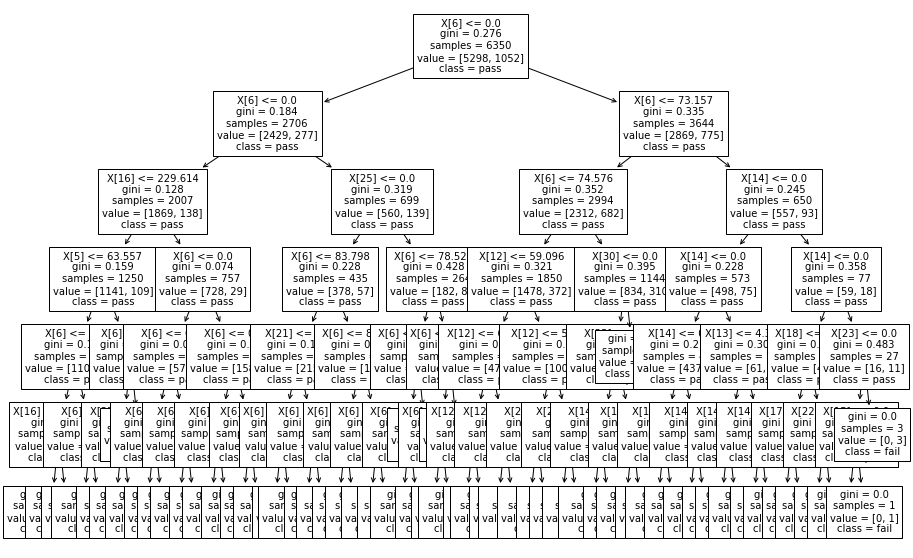

In [33]:
print(model.feature_importance())
model.plot_tree()
#df.columns[8]

In [ ]:
print(model.evaluate(X_val, y_val, False, True))